In [2]:
from google.colab import files

uploaded = files.upload()

Saving reviews_dataset.csv to reviews_dataset.csv


In [5]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [6]:

# Load dataset
df = pd.read_csv('reviews_dataset.csv')

# Define text preprocessing functions
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Apply text preprocessing
df['ReviewContent'] = df['ReviewContent'].apply(remove_punctuation)
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['ReviewContent'] = df['ReviewContent'].apply(remove_stopwords)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['ReviewContent'] = df['ReviewContent'].apply(lemmatize_text)

# Encode categorical variables
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])
df['Generation_encoded'] = label_encoder.fit_transform(df['Generation'])
df['Sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])
df['Country_encoded'] = label_encoder.fit_transform(df['Country'])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


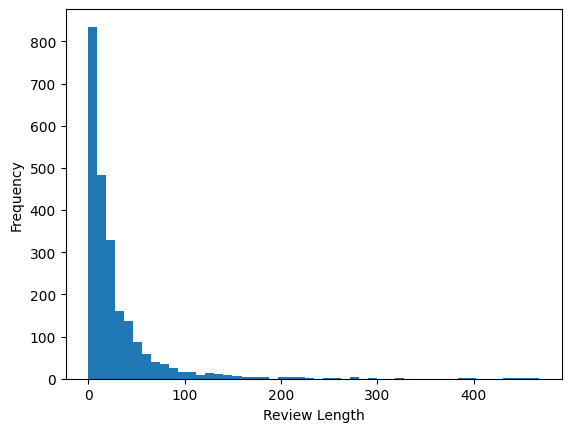

In [7]:
# Define features and target variable
X = df['ReviewContent']
y = df['Sentiment_encoded']

# Stratified split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Analyze the length distribution of the sequences
review_lengths = [len(seq) for seq in X_train_seq]
plt.hist(review_lengths, bins=50)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Set max_len based on the 100th percentile length (longest review)
max_len = np.percentile(review_lengths, 100).astype(int)  # Use 100th percentile length

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [14]:


# Define the ANN model
embedding_dim = 512

model_ann = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Assuming 4 classes
])

model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_ann.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_ann = model_ann.fit(
    X_train_pad, y_train,
    epochs=13,  # Adjust epochs as needed
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    #callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 468, 512)          2560000   
                                                                 
 flatten_2 (Flatten)         (None, 239616)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               30670976  
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                

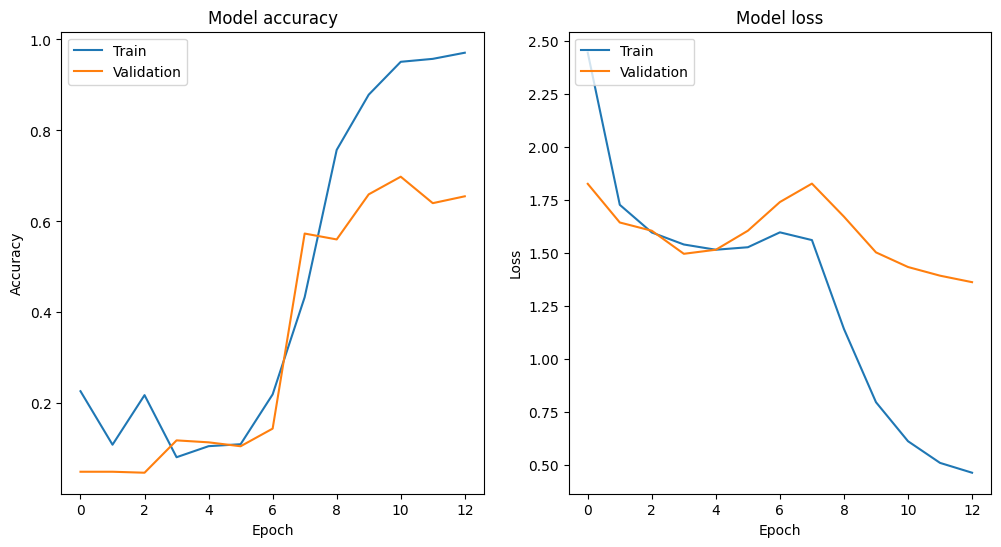

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'])
plt.plot(history_ann.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'])
plt.plot(history_ann.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [13]:
# Evaluate the model
y_pred_ann = model_ann.predict(X_test_pad)
y_pred_classes_ann = np.argmax(y_pred_ann, axis=1)

# Classification report
print("Classification Report (ANN):")
print(classification_report(y_test, y_pred_classes_ann))

# Accuracy
accuracy_ann = accuracy_score(y_test, y_pred_classes_ann)
print(f"Accuracy (ANN): {accuracy_ann:.2f}")

32/32 [==============================] - 1s 40ms/step
Classification Report (ANN):
              precision    recall  f1-score   support

           0       0.24      0.12      0.16       125
           1       0.16      0.11      0.13        53
           2       0.40      0.35      0.37       117
           3       0.75      0.85      0.80       698

    accuracy                           0.66       993
   macro avg       0.39      0.36      0.37       993
weighted avg       0.61      0.66      0.63       993

Accuracy (ANN): 0.66
